# Imports

In the first step of our task, lets import some libraries and keep a place for all of our import operations. New imports will be added here once we need them. Please make sure to put a comment about why you are importing it and where it is needed so that when we come here later, we won't get confused.

In [318]:
!pip install nltk
!pip install simpletransformers
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [319]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import re
import string
import math
import spacy
import nltk 
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split # Required for train-test split
from sklearn.feature_extraction.text import CountVectorizer # Required for vectorizing the data
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text 

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

from IPython.display import HTML
def pretty_print_df(value_counts_):
  "Quick function to display value counts more nicely"
  display(HTML(pd.DataFrame(value_counts_).to_html()))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Get the Data
Let's read the CSV data from GitHub and see how the data is stored in the file by printing first few rows.

In [320]:
df= pd.read_csv("https://raw.githubusercontent.com/sureshrgmi/AML_Coursework_Data/main/processed_reviews_split_surnamesRSTU_minimal.csv")
df.sample(5)

,review_id,text,confidence_score,review_score,acceptance_status
5813,iclr_review_5813,Structured Exploration via Hierarchical Variat...,3.0,5.0,Reject
4879,iclr_review_4879,Symmetry and Systematicity. We argue that symm...,NaN,3.0,Reject
2779,iclr_review_2779,Filling the Soap Bubbles: Efficient Black-Box ...,NaN,3.0,Reject
3945,iclr_review_3945,Supervised Policy Update for Deep Reinforcemen...,3.0,6.0,Accept
1013,iclr_review_1013,Power up! Robust Graph Convolutional Network b...,NaN,3.0,Reject


# EDA and Data Cleansing

In this step, we will explore our data to find out more about it. We will help us to see how the data is distributed and to check the quality of our data. We can use different measures such as min, max, count, standard deviation to see and assess our data. Also, we could see if there is incorrect data in our dataframe and analyze it's impact on our application before finally improving them using correct measures.

The data we are going to analyze here is a peer-review data from International Conference of Learning Representation (2017 to 2020). The data has following fields

1.   REVIEW_ID
2.   TEXT
3.   CONFIDENCE_SCORE
4.   REVIEW_SCORE
5.   ACCEPTANCE_STATUS


In [321]:
# Assign our data frame into new data frame
df_clean=df

See the dataframe info

In [322]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          6118 non-null   object 
 1   text               6034 non-null   object 
 2   confidence_score   3306 non-null   float64
 3   review_score       6118 non-null   float64
 4   acceptance_status  5733 non-null   object 
dtypes: float64(2), object(3)
memory usage: 239.1+ KB


Here, we can see that the total no of entries and total not null entries for each of the column aer different. Except for the columns review_id and review_score, we can see NULL values for the columns. Lets further analyse those records.

In [323]:
# Get the count of records that has duplicate value (combination of all columns)
print(df_clean.duplicated().sum())

0


Lets see how may duplicate records are there for the field text.

In [324]:
print(df_clean['text'].duplicated().sum())

505


We have 505 duplicates for the field text, lets further analyze the data by printing them.

In [325]:
df_clean[df_clean['text'].duplicated()].head(10)

,review_id,text,confidence_score,review_score,acceptance_status
66,iclr_review_0066,NaN,NaN,3.0,Reject
119,iclr_review_0119,NaN,NaN,3.0,Reject
194,iclr_review_0194,#. #. #. #,3.0,7.0,Reject
259,iclr_review_0259,NaN,3.0,7.0,Accept
279,iclr_review_0279,NaN,4.0,7.0,Accept
290,iclr_review_0290,#. #. #. #,NaN,3.0,Reject
296,iclr_review_0296,NaN,2.0,7.0,Accept
322,iclr_review_0322,#. #. #. #,4.0,7.0,Accept
403,iclr_review_0403,#. #. #. #,3.0,5.0,Reject
407,iclr_review_0407,NaN,NaN,3.0,Reject


We could see that there are a lot of duplicate records and most of them have #.#.#.# in the text field. Let's further explore by printing fields having text lengthe less than 10.

In [326]:
df_clean[df_clean['text'].str.len()<15].head(10)

,review_id,text,confidence_score,review_score,acceptance_status
176,iclr_review_0176,#. #. #. #,NaN,6.0,Accept
194,iclr_review_0194,#. #. #. #,3.0,7.0,Reject
290,iclr_review_0290,#. #. #. #,NaN,3.0,Reject
322,iclr_review_0322,#. #. #. #,4.0,7.0,Accept
403,iclr_review_0403,#. #. #. #,3.0,5.0,Reject
457,iclr_review_0457,#. #. #. #,5.0,7.0,Reject
489,iclr_review_0489,#. #. #. #,4.0,4.0,Reject
507,iclr_review_0507,#. #. #. #,NaN,3.0,Reject
582,iclr_review_0582,#. #. #. #,3.0,5.0,Reject
610,iclr_review_0610,#. #. #. #,4.0,7.0,Accept


These records (#. #. #. #) does not present any significant value to our algorithm, rather they could affect the accuracy of it. So, lets delete them from our dataframe.

df_removed is the dataframe that has all remoced records

In [327]:
df_removed=df_clean[df_clean['text'].str.len()<15]
df_clean= df_clean[df_clean['text'].str.len()>15]

let's add the reason for the removal in new column


In [328]:
df_removed = df_removed.assign(reason='Has string length less than 15')


In [329]:
df_removed.head()

,review_id,text,confidence_score,review_score,acceptance_status,reason
176,iclr_review_0176,#. #. #. #,NaN,6.0,Accept,Has string length less than 15
194,iclr_review_0194,#. #. #. #,3.0,7.0,Reject,Has string length less than 15
290,iclr_review_0290,#. #. #. #,NaN,3.0,Reject,Has string length less than 15
322,iclr_review_0322,#. #. #. #,4.0,7.0,Accept,Has string length less than 15
403,iclr_review_0403,#. #. #. #,3.0,5.0,Reject,Has string length less than 15


In [330]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5950 entries, 0 to 6117
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          5950 non-null   object 
 1   text               5950 non-null   object 
 2   confidence_score   3208 non-null   float64
 3   review_score       5950 non-null   float64
 4   acceptance_status  5569 non-null   object 
dtypes: float64(2), object(3)
memory usage: 278.9+ KB


In [331]:
# Get total no of null values for each of the column
print(df_clean.isnull().sum())

review_id               0
text                    0
confidence_score     2742
review_score            0
acceptance_status     381
dtype: int64


We have 381 records in the data farame which doesn't have acceptance status field. As the field confidence_score is optional, we will not check and remove the field even if it has almost half of the records null. Let's delete those rows as they are not significant for our analysis.

Before deleting these null records, let's first add them to our df_removed dataframe to keep track of removed records.

In [332]:
df_removed=df_removed.append(df_clean[df_clean['acceptance_status'].isnull()])

In [333]:
df_removed.sample(10)

,review_id,text,confidence_score,review_score,acceptance_status,reason
2904,iclr_review_2904,PAC-Bayes Few-shot Meta-learning with Implicit...,NaN,1.0,NaN,NaN
4459,iclr_review_4459,#. #. #. #,4.0,5.0,Reject,Has string length less than 15
1539,iclr_review_1539,Geometry-Aware Visual Predictive Models of Int...,NaN,6.0,NaN,NaN
2804,iclr_review_2804,Should All Cross-Lingual Embeddings Speak Engl...,NaN,3.0,NaN,NaN
281,iclr_review_0281,Super-AND: A Holistic Approach to Unsupervised...,NaN,3.0,NaN,NaN
3912,iclr_review_3912,#. #. #. #,NaN,1.0,Reject,Has string length less than 15
2851,iclr_review_2851,"Study of a Simple, Expressive and Consistent G...",NaN,3.0,NaN,NaN
1289,iclr_review_1289,On the Anomalous Generalization of GANs. Gener...,NaN,6.0,NaN,NaN
2011,iclr_review_2011,Interactive Classification by Asking Informati...,NaN,1.0,NaN,NaN
2594,iclr_review_2594,Depth-Adaptive Transformer. State of the art s...,NaN,6.0,NaN,NaN


In [334]:
df_removed['reason']=df_removed['reason'].fillna('Null Acceptance Status')

In [335]:
# Remove the rows that has acceptance_status field values null
df_clean = df_clean[df_clean['acceptance_status'].notna()]

Let's do some further analysis by calculatiing different matrices such as mean, min, max, standard deviation, quartiles etc. for the fields having numeric values.


In [336]:
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
confidence_score,3208.0,3.780237,0.819178,1.0,3.0,4.0,4.0,5.0
review_score,5569.0,4.795834,2.116695,-1.0,3.0,5.0,6.0,10.0


Looks like we have record/s having review score value in negative. It will impact our data so lets remove it from our Data Frame.

In [337]:
df_removed.sample(10)

,review_id,text,confidence_score,review_score,acceptance_status,reason
5037,iclr_review_5037,SCL: Towards Accurate Domain Adaptive Object D...,NaN,3.0,NaN,Null Acceptance Status
1555,iclr_review_1555,Better Optimization for Neural Architecture Se...,NaN,3.0,NaN,Null Acceptance Status
5614,iclr_review_5614,Open-Set Domain Adaptation with Category-Agnos...,NaN,3.0,NaN,Null Acceptance Status
1311,iclr_review_1311,Unsupervised Few-shot Object Recognition by In...,NaN,1.0,NaN,Null Acceptance Status
4456,iclr_review_4456,Empirical observations pertaining to learned p...,NaN,3.0,NaN,Null Acceptance Status
5498,iclr_review_5498,Imbalanced Classification via Adversarial Mino...,NaN,3.0,NaN,Null Acceptance Status
2232,iclr_review_2232,Generalizing Natural Language Analysis through...,NaN,3.0,NaN,Null Acceptance Status
947,iclr_review_0947,Parameterized Action Reinforcement Learning fo...,NaN,3.0,NaN,Null Acceptance Status
5819,iclr_review_5819,#. #. #. #,3.0,5.0,Accept,Has string length less than 15
3499,iclr_review_3499,Natural Language Adversarial Attack and Defens...,NaN,3.0,NaN,Null Acceptance Status


In [338]:
df_removed=df_removed.append(df_clean[df_clean['review_score'].lt(0)])

In [339]:
df_removed['reason']=df_removed['reason'].fillna('Review score less than 1')

In [340]:
df_removed.sample(10)

,review_id,text,confidence_score,review_score,acceptance_status,reason
5319,iclr_review_5319,Pruning Depthwise Separable Convolutions for E...,NaN,3.0,NaN,Null Acceptance Status
3769,iclr_review_3769,From Here to There: Video Inbetweening Using D...,NaN,3.0,NaN,Null Acceptance Status
5107,iclr_review_5107,Partially Mutual Exclusive Softmax for Positiv...,4.0,-1.0,Reject,Review score less than 1
3318,iclr_review_3318,On the Geometry of Adversarial Examples. Adver...,3.0,-1.0,Reject,Review score less than 1
1927,iclr_review_1927,ReMixMatch: Semi-Supervised Learning with Dist...,NaN,-1.0,Accept,Review score less than 1
5519,iclr_review_5519,Molecule Property Prediction and Classificatio...,NaN,3.0,NaN,Null Acceptance Status
6036,iclr_review_6036,#. #. #. #,NaN,3.0,Reject,Has string length less than 15
6037,iclr_review_6037,Soft Value Iteration Networks for Planetary Ro...,4.0,-1.0,Reject,Review score less than 1
1172,iclr_review_1172,#. #. #. #,4.0,6.0,Reject,Has string length less than 15
3521,iclr_review_3521,Hardware-aware One-Shot Neural Architecture Se...,NaN,3.0,NaN,Null Acceptance Status


In [341]:
df_clean=df_clean[df_clean["review_score"].ge(1)]

Now, lets analyse the categorical columns and the distinct values we have for those columns.

In [342]:
# let's list all categorical features
categorical_columns= ['confidence_score', 'review_score', 'acceptance_status']

# let's get the categories and their count for each distinct features
for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(df_clean[col].value_counts())
  print()

Categories and number of occurrences for 'confidence_score'


,confidence_score
4.0,1560
3.0,824
5.0,544
2.0,163
1.0,25



Categories and number of occurrences for 'review_score'


,review_score
6.0,1527
3.0,1134
5.0,685
4.0,611
7.0,579
8.0,442
1.0,327
2.0,63
9.0,39
10.0,4



Categories and number of occurrences for 'acceptance_status'


,acceptance_status
Reject,3474
Accept,1937


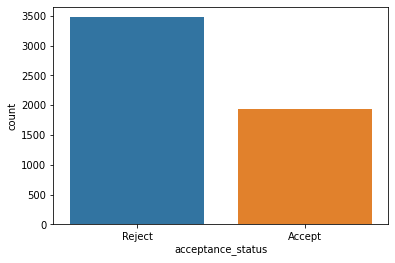

In [343]:
sns.countplot(x ='acceptance_status', data = df_clean)
plt.show()


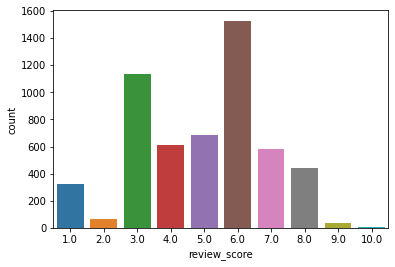

In [344]:
sns.countplot(x ='review_score', data = df_clean)
plt.show()


Let's see how the data looks like for the reviews with review score 10

In [345]:
df_clean.loc[df_clean['review_score'] == 10]

,review_id,text,confidence_score,review_score,acceptance_status
163,iclr_review_0163,Towards Principled Methods for Training Genera...,5.0,10.0,Accept
2160,iclr_review_2160,ALISTA: Analytic Weights Are As Good As Learne...,5.0,10.0,Accept
3515,iclr_review_3515,A Theoretical Framework for Robustness of (Dee...,4.0,10.0,Accept
4801,iclr_review_4801,Towards Principled Methods for Training Genera...,5.0,10.0,Accept


Plotting the histogram based on the length of each review text.

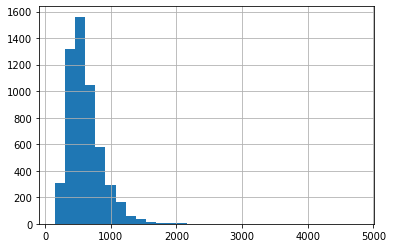

In [346]:
seq_len = [len(i.split()) for i in df_clean['text']]

pd.Series(seq_len).hist(bins=30)


Now let's drop the column confidence_score from our dataset as we will not be using them in our analysis.

In [347]:
df_clean.drop('confidence_score', axis=1, inplace=True)

In [348]:
df_clean.head()

,review_id,text,review_score,acceptance_status
0,iclr_review_0000,Selective Self-Training for semi-supervised Le...,5.0,Reject
1,iclr_review_0001,Time-Agnostic Prediction: Predicting Predictab...,7.0,Accept
2,iclr_review_0002,Policy Optimization In the Face of Uncertainty...,1.0,Reject
3,iclr_review_0003,Adversarial Learning for Semi-Supervised Seman...,5.0,Reject
4,iclr_review_0004,Analysis and Interpretation of Deep CNN Repres...,3.0,Reject


## Export removed data to drive

In [349]:
from google.colab import drive
drive.mount('drive')
df_removed.to_csv('/content/drive/My Drive/removed_data.csv', encoding='utf-8', index=False)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Encoding the Data

Now, lets encode our categorical text fields with numerical values. This means, our acceptance status columns should be encoded to 0 and 1 for Reject and Accept values.

We will be using the Label Encoder feature provided by sklearn library.

In [350]:
df_encoded=df_clean

In [351]:
#Let's put cleaned data frame in a different data frame name dc_encoded
le=LabelEncoder()
df_encoded["acceptance_status"]=le.fit_transform(df_encoded["acceptance_status"])
df_encoded["acceptance_status"]=le.fit_transform(-df_encoded["acceptance_status"])
df_encoded["review_score"]=le.fit_transform(df_encoded["review_score"])

# df_encoded["review_score"]=df_encoded["review_score"].astype(int)


In [352]:
df_encoded.head()

,review_id,text,review_score,acceptance_status
0,iclr_review_0000,Selective Self-Training for semi-supervised Le...,4,0
1,iclr_review_0001,Time-Agnostic Prediction: Predicting Predictab...,6,1
2,iclr_review_0002,Policy Optimization In the Face of Uncertainty...,0,0
3,iclr_review_0003,Adversarial Learning for Semi-Supervised Seman...,4,0
4,iclr_review_0004,Analysis and Interpretation of Deep CNN Repres...,2,0


# Text Preprocessing

In this step, we will clean out text data and try to make them uniform so that we get a better result from them. Usually the data contains various forms of emotions, puncutatuin, text in different cases, special characters and stop words.

In [353]:
df_preprocessed=df_encoded

In [354]:
# Let's see what our single text field contains
df_preprocessed['text'][0]


'Selective Self-Training for semi-supervised Learning. Semi-supervised learning (SSL) is a study that efficiently exploits a large amount of unlabeled data to improve performance in conditions of limited labeled data. Most of the conventional SSL methods assume that the classes of unlabeled data are included in the set of classes of labeled data. In addition, these methods do not sort out useless unlabeled samples and use all the unlabeled data for learning, which is not suitable for realistic situations. In this paper, we propose an SSL method called selective self-training (SST), which selectively decides whether to include each unlabeled sample in the training process. It is also designed to be applied to a more real situation where classes of unlabeled data are different from the ones of the labeled data. For the conventional SSL problems which deal with data where both the labeled and unlabeled samples share the same class categories, the proposed method not only performs comparab

We can see a lot of noise in our data such as special characters, extra space hyphens etc. Our main goal in this step would be to eliminate the factors that may contribute to low accuracy in our model. 

Following are the list of actions we are going to perform in order on our data.


1.   Converting to lowercase
2.   Removing puncuation and whitespace
3.   Removing stop words
4.   Lemmatization





## Converting to Lowercase

In [355]:
df_preprocessed = df_preprocessed.applymap(lambda s: s.lower() if type(s) == str else s)

In [356]:
df_preprocessed['text'][0]

'selective self-training for semi-supervised learning. semi-supervised learning (ssl) is a study that efficiently exploits a large amount of unlabeled data to improve performance in conditions of limited labeled data. most of the conventional ssl methods assume that the classes of unlabeled data are included in the set of classes of labeled data. in addition, these methods do not sort out useless unlabeled samples and use all the unlabeled data for learning, which is not suitable for realistic situations. in this paper, we propose an ssl method called selective self-training (sst), which selectively decides whether to include each unlabeled sample in the training process. it is also designed to be applied to a more real situation where classes of unlabeled data are different from the ones of the labeled data. for the conventional ssl problems which deal with data where both the labeled and unlabeled samples share the same class categories, the proposed method not only performs comparab

## Remove punctuation and whitespace

In [357]:
df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [358]:
df_preprocessed['text'][0]

'selective selftraining for semisupervised learning semisupervised learning ssl is a study that efficiently exploits a large amount of unlabeled data to improve performance in conditions of limited labeled data most of the conventional ssl methods assume that the classes of unlabeled data are included in the set of classes of labeled data in addition these methods do not sort out useless unlabeled samples and use all the unlabeled data for learning which is not suitable for realistic situations in this paper we propose an ssl method called selective selftraining sst which selectively decides whether to include each unlabeled sample in the training process it is also designed to be applied to a more real situation where classes of unlabeled data are different from the ones of the labeled data for the conventional ssl problems which deal with data where both the labeled and unlabeled samples share the same class categories the proposed method not only performs comparable to other convent

## Removing digits

In [359]:
df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub('W*dw*','',x))

In [360]:
df_preprocessed['text'][0]

'selective selftraining for semisupervise learning semisupervise learning ssl is a stuy that efficiently exploits a large amount of unlabele ata to improve performance in conitions of limite labele ata most of the conventional ssl methos assume that the classes of unlabele ata are inclue in the set of classes of labele ata in aition these methos o not sort out useless unlabele samples an use all the unlabele ata for learning which is not suitable for realistic situations in this paper we propose an ssl metho calle selective selftraining sst which selectively ecies whether to inclue each unlabele sample in the training process it is also esigne to be applie to a more real situation where classes of unlabele ata are ifferent from the ones of the labele ata for the conventional ssl problems which eal with ata where both the labele an unlabele samples share the same class categories the propose metho not only performs comparable to other conventional ssl algorithms but also can be combine 

## Removing Stop Words

In [361]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: remove_stopwords(x))

In [362]:
df_preprocessed['text'][0]

'selective selftraining semisupervise learning semisupervise learning ssl stuy efficiently exploits large amount unlabele ata improve performance conitions limite labele ata conventional ssl methos assume classes unlabele ata inclue set classes labele ata aition methos sort useless unlabele samples use unlabele ata learning suitable realistic situations paper propose ssl metho calle selective selftraining sst selectively ecies whether inclue unlabele sample training process also esigne applie real situation classes unlabele ata ifferent ones labele ata conventional ssl problems eal ata labele unlabele samples share class categories propose metho performs comparable conventional ssl algorithms also combine ssl algorithms conventional methos cannot applie new ssl problems separate ata share classes metho oes show performance egraation even classes unlabele ata ifferent labele ata novel interesting paper important topic semisupervise learning even though propose approach seems significant

## Lemmatization

In [363]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
df_preprocessed["text"] = df_preprocessed["text"].apply(lambda text: lemmatize_words(text))

In [364]:
df_preprocessed.head()

,review_id,text,review_score,acceptance_status
0,iclr_review_0000,selective selftraining semisupervise learning ...,4,0
1,iclr_review_0001,timeagnostic preiction preicting preictable vi...,6,1
2,iclr_review_0002,policy optimization face uncertainty moelbase ...,0,0
3,iclr_review_0003,aversarial learning semisupervise semantic seg...,4,0
4,iclr_review_0004,analysis interpretation eep cnn representation...,2,0


# Upsampling the binary classification data for BERT

Let's create a new dataframe for this process from the encoded data.

In [365]:
df_before_upsample=df_encoded

Split rejected and accepted data in different dataframes

In [366]:
reject = df_before_upsample[df_before_upsample["acceptance_status"] == 0]
accept  = df_before_upsample[df_before_upsample["acceptance_status"] == 1]

Upsample data that have lowe no of values (Accepted papers)

In [367]:
from sklearn.utils import resample
text_upsample = resample(accept,
             replace=True,
             n_samples=len(reject),
             random_state=42)

print(text_upsample.shape)

(3474, 4)


Concat the data into single dataframe as df_after_upsample

In [368]:
df_after_upsample = pd.concat([reject, text_upsample])

In [369]:
df_after_upsample.sample(10)

,review_id,text,review_score,acceptance_status
4875,iclr_review_4875,ROS-HPL: Robotic Object Search with Hierarchic...,2,0
2781,iclr_review_2781,Learning Procedural Abstractions and Evaluatin...,5,1
4390,iclr_review_4390,Inductive Matrix Completion Based on Graph Neu...,5,1
4573,iclr_review_4573,Local minima in training of deep networks. The...,2,0
1336,iclr_review_1336,Automatically Inferring Data Quality for Spati...,7,1
1051,iclr_review_1051,Value Propagation Networks. We present Value P...,6,1
531,iclr_review_0531,Reasoning with Memory Augmented Neural Network...,6,1
4950,iclr_review_4950,Incremental Learning through Deep Adaptation. ...,3,0
3957,iclr_review_3957,Adversarial reading networks for machine compr...,4,0
4063,iclr_review_4063,Continual Learning using the SHDL Framework wi...,0,0


Plot the distribution of resampled data

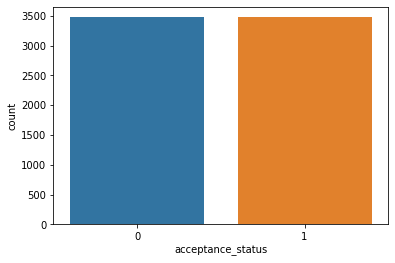

In [370]:
sns.countplot(x ='acceptance_status', data = df_after_upsample)
plt.show()

# Data Augmentation

### Augmenting the data

Data augmentation is the process of generating extra data based on the data you already have. This is one of the widely used method to handle the unbalanced dataset in NLP applications and to improve the accuracy of the algorithm. In our data examples, we coluld see that the data is unbalanced for accept and reject case and also for the review score. The number of rejected paper and accepted paper have 65% - 35% distribution. While in  the case of review score, scores 10, 9 and 2 are significantly less than others while 6 is significantly high. 

Let's see the data distribution before augmentation.

In [371]:
df1_before_aug=df_encoded

In [372]:
pd.value_counts(df1_before_aug.acceptance_status)

0    3474
1    1937
Name: acceptance_status, dtype: int64

Here, we can see that type-0 (Rejected Papers) values are significantly higher than the type-1 (Accepted Papers). Now, let's try to augment to increase the data for accepted papers.

In [373]:
!pip install tqdm
!pip install transformers
!pip install nlpaug

from tqdm import trange
from tqdm.auto import tqdm
from sklearn.utils import shuffle
import nlpaug.augmenter.word.context_word_embs as aug

augmenter= aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert')

# Define method to augment data that has acceptance status value 1

def augDF(df1_before_aug, augmenter, repetitions=1, samples=500):
    augmented_texts = []
    # select the accepted papers only as it has less no of sample records
    accept_df = df1_before_aug[df1_before_aug['acceptance_status'] == 1].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(accept_df), samples)):
        # generating augmented text records
        for _ in range(repetitions):
            augmented_text = augmenter.augment(accept_df['text'].iloc[i])
            augmented_texts.append(augmented_text)
    data = {
        'acceptance_status': 1,
        'text': augmented_texts
    }
    df1_after_aug = pd.DataFrame(data)
    df1_after_aug = shuffle(df1_before_aug.append(df1_after_aug).reset_index(drop=True))
    return df1_after_aug

# Run the data augmentation method (we can increase the sampes value to 2000 - not doing it as it takse a lot of time)
df1_after_aug=augDF(df1_before_aug, augmenter, samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

Let's see the distribution after augmentation

In [374]:
pd.value_counts(df1_after_aug.acceptance_status)

0    3474
1    2437
Name: acceptance_status, dtype: int64

# 1.Multiclass Classification using BERT

As BERT works with text, we will be using the raw text file for feeding to it.

In [375]:
df_bert_multi=df_encoded

## Train Test Splitting

In [376]:
X = df_bert_multi["text"]
y = df_bert_multi["review_score"]

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)


## Model Parameters

In [378]:
model_args = ClassificationArgs()
model_args.num_train_epochs = 10
model_args.learning_rate = 5e-4
model_args.train_batch_size =8
model_args.overwrite_output_dir = True

## Modelling

In [379]:
# model = ClassificationModel("bert", "bert-base-cased",num_labels =10 ,args=model_args, use_cuda=False)
model = ClassificationModel("bert", "bert-base-cased",num_labels =10 ,args=model_args, use_cuda=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [380]:
train_df = pd.DataFrame({"text":X_train, "labels":y_train})
eval_df = pd.DataFrame({"text":X_test, "labels":y_test})

train_df.head()

,text,labels
2153,Improved Sample Complexities for Deep Neural N...,2
687,Multi-Agent Cooperation and the Emergence of (...,6
3957,Adversarial reading networks for machine compr...,4
2601,A Neural Stochastic Volatility Model. In this ...,5
696,Wasserstein-Bounded Generative Adversarial Net...,2


In [381]:
model.train_model(train_df, acc=accuracy_score)

  0%|          | 0/4328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/541 [00:00<?, ?it/s]

(5410, 1.934446956049272)

## Result

In [382]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)

  0%|          | 0/1083 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/136 [00:00<?, ?it/s]

In [383]:
result

{'acc': 0.26223453370267774, 'eval_loss': 1.9308519556241877, 'mcc': 0.0}

## Predicting the result

In [384]:
sample_dataset = ['Parametric Adversarial Divergences are Good Task Losses for Generative Modeling. Generative modeling of high dimensional data like images is a notoriously difficult and ill-defined problem. In particular, how to evaluate a learned generative model is unclear. In this paper, we argue that *adversarial learning*, pioneered with generative adversarial networks (GANs), provides an interesting framework to implicitly define more meaningful task losses for unsupervised tasks, such as for generating "visually realistic" images. By relating GANs and structured prediction under the framework of statistical decision theory, we put into light links between recent advances in structured prediction theory and the choice of the divergence in GANs. We argue that the insights about the notions of "hard" and "easy" to learn losses can be analogously extended to adversarial divergences. We also discuss the attractive properties of parametric adversarial divergences for generative modeling, and perform experiments to show the importance of choosing a divergence that reflects the final task.. This paper takes some steps in the direction of understanding adversarial learning/GAN and relating GANs and structured prediction under statistical decision theory framework. One of the main contribution of the paper is to study/analyze parametric adversarial divergences and link it with structured losses. Although, I see a value in the idea considered in the paper, it is not clear to me how much novelty does this work bring on top of the following two papers: 1) S. Liu. Approximation and convergence properties of generative adversarial learning. In NIPS, 2017. 2) S. Arora. Generalization and equilibrium in generative adversarial nets (GANs). In ICML, 2017. Most of their theoretical results seems to be already existing in literature (Liu, Arora, Arjovsky) in some form of other and it is claimed that this paper put these result in perspective in an attempt to provide a more principled view of the nature and usefulness of adversarial divergences, in comparison to traditional divergences. However, it seems to me that the paper is limited both in theoretical novelty and practical usefulness of these results. Especially, I could not see any novel contribution for GAN literature or adversarial divergences. I would suggests authors to clearly specify novelties and contrast their work with 1) GAN literature: ([2] Arora*s results) 2) Adversarial divergences literature: ([1] Liu) Also, provide more experiments to support several claims (without any rigorous theoretical justifications) made in the paper..	']

In [385]:
model.predict(sample_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([5]),
 array([[-0.34912109, -2.20117188,  1.03515625,  0.44262695,  0.49487305,
          1.39355469,  0.29785156,  0.09130859, -2.73242188, -4.72265625]]))

# 2.Classification using BERT
Creating a new dataframe from out encoded dataframe before performing any action on it.

In [386]:
df_bert=df_encoded

## Train Test Split

In [387]:
X = df_bert["text"]
y = df_bert["acceptance_status"]

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

## Defining Model Parameters

In [389]:
model_args = ClassificationArgs()
model_args.num_train_epochs = 2
model_args.learning_rate = 1e-4
model_args.overwrite_output_dir = True

## Modelling

In [390]:
model_acceptance_status = ClassificationModel("bert", "bert-base-uncased",num_labels = 2,args=model_args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [391]:
train_df = pd.DataFrame({"text":X_train, "acceptance_status":y_train})
eval_df = pd.DataFrame({"text":X_test, "acceptance_status":y_test})

In [392]:
train_df.sample(10)

,text,acceptance_status
741,Towards Language Agnostic Universal Representa...,0
3176,Learning to remember: Dynamic Generative Memor...,0
4128,BLOCK-NORMALIZED GRADIENT METHOD: AN EMPIRICAL...,0
5010,Unsupervised Hierarchical Video Prediction. Mu...,0
3611,A New Method of Region Embedding for Text Clas...,1
603,Monotonic Chunkwise Attention. Sequence-to-seq...,1
5257,Learning to Navigate the Web. Learning in envi...,1
1153,Distributed Online Optimization with Long-Term...,0
2350,Situating Sentence Embedders with Nearest Neig...,0
3824,Wyner VAE: A Variational Autoencoder with Succ...,0


In [393]:
model_acceptance_status.train_model(train_df, acc=accuracy_score, use_cuda=True)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/4328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/541 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/541 [00:00<?, ?it/s]

(1082, 0.6604653180416763)

In [394]:
result, model_outputs, wrong_predictions = model_acceptance_status.eval_model(eval_df, acc=accuracy_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1083 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/136 [00:00<?, ?it/s]

## Performance Metrices

In [395]:
result

{'acc': 0.6398891966759003,
 'auprc': 0.4254990624850381,
 'auroc': 0.5835405335405335,
 'eval_loss': 0.6543633705552887,
 'fn': 390,
 'fp': 0,
 'mcc': 0.0,
 'tn': 693,
 'tp': 0}

## Predicting the model

In [396]:
# model_acceptance_status.predict(vectText)  # predicts class of the text


In [397]:
# text_list = list(df_bert['text'].tail(10))
# result_list= list(df_bert['review_score'].tail(10))
# print("Actual review score:")
# print(result_list)
# result=[]
# # vectText = vectorizer.transform(np.array(text_list))  # vectorizes the text

# prediction = model_acceptance_status.predict(text_list)  # predicts class of the text
# for enum, i in enumerate(text_list):
#   result.append(prediction[enum])
# print("\nPredicted review score")
# print(result)

# 3.Multiclass Classification using Logistic Regression

In [398]:
df_logistic_multi=df_encoded

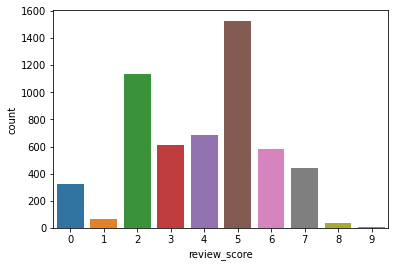

In [399]:
sns.countplot(x ='review_score', data = df_logistic_multi)
plt.show()

In [400]:
df_logistic_multi.head()

,review_id,text,review_score,acceptance_status
0,iclr_review_0000,Selective Self-Training for semi-supervised Le...,4,0
1,iclr_review_0001,Time-Agnostic Prediction: Predicting Predictab...,6,1
2,iclr_review_0002,Policy Optimization In the Face of Uncertainty...,0,0
3,iclr_review_0003,Adversarial Learning for Semi-Supervised Seman...,4,0
4,iclr_review_0004,Analysis and Interpretation of Deep CNN Repres...,2,0


## Train Test Split

In [401]:
X=df_logistic_multi.text.values
y=df_logistic_multi.review_score.values

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, stratify=y, random_state=32 )

See the shape of training and testing data...

In [402]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3787,), (3787,), (1624,), (1624,))

## Vectorizing using count vectorizer

In [403]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

## Finding the best parameter combination using Hyperparameter Tunning

In [404]:
logmodel = LogisticRegression(multi_class='ovr')

param_grid=[{
'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
'C' : np.logspace(-4, 4,20),
'solver':['lbfgs'],
    'max_iter' : [10,100, 1000,2500, 5000]
    }
]

In [405]:
from sklearn.model_selection import GridSearchCV
clf= GridSearchCV(logmodel, param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)
best_clf=clf.fit(X_train,y_train)

Fitting 2 folds for each of 400 candidates, totalling 800 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
400 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

In [406]:
best_clf.best_estimator_

LogisticRegression(C=0.0018329807108324356, max_iter=1000, multi_class='ovr')

## Applying Logistic Regression

In [407]:
classifier_review_score = LogisticRegression(C=0.0018329807108324356, max_iter=1000, multi_class='ovr')
classifier_review_score.fit(X_train, y_train)

score = classifier_review_score.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.34421182266009853


In [408]:
y_pred = classifier_review_score.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=df_logistic_multi.review_score.unique())
df_cm = pd.DataFrame(cm, index=df_logistic_multi.review_score.unique(), columns=df_logistic_multi.review_score.unique())
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,4,6,0,2,3,5,7,1,9,8
4,0.300000,0.144928,0.083333,0.078947,0.254386,0.106061,0.130435,NaN,NaN,NaN
6,0.123077,0.202899,0.000000,0.035885,0.052632,0.139860,0.130435,NaN,NaN,NaN
0,0.000000,0.014493,0.416667,0.143541,0.052632,0.030303,0.000000,NaN,NaN,NaN
2,0.046154,0.072464,0.250000,0.385167,0.157895,0.167832,0.130435,NaN,NaN,NaN
3,0.253846,0.144928,0.000000,0.098086,0.307018,0.073427,0.043478,NaN,NaN,NaN
5,0.215385,0.275362,0.166667,0.217703,0.122807,0.347319,0.260870,NaN,NaN,NaN
7,0.030769,0.115942,0.083333,0.031100,0.017544,0.114219,0.304348,NaN,NaN,NaN
1,0.023077,0.014493,0.000000,0.007177,0.035088,0.009324,0.000000,NaN,NaN,NaN
9,0.000000,0.000000,0.000000,0.002392,0.000000,0.000000,0.000000,NaN,NaN,NaN
8,0.007692,0.014493,0.000000,0.000000,0.000000,0.011655,0.000000,NaN,NaN,NaN


## Accuracy Score

In [409]:
print("Accuracy Score : ", accuracy_score(y_test, y_pred)*100,'%')

Accuracy Score :  34.42118226600985 %


In [410]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.05      0.09        98
           1       0.00      0.00      0.00        19
           2       0.39      0.47      0.42       340
           3       0.31      0.19      0.24       183
           4       0.30      0.19      0.23       206
           5       0.35      0.65      0.45       458
           6       0.20      0.08      0.12       174
           7       0.30      0.05      0.09       133
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         1

    accuracy                           0.34      1624
   macro avg       0.23      0.17      0.16      1624
weighted avg       0.32      0.34      0.30      1624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predicting the model

In [411]:
text_list = list(df_logistic_multi['text'].tail(10))
result_list= list(df_logistic_multi['review_score'].tail(10))
print("Actual review score:")
print(result_list)
result=[]
vectText = vectorizer.transform(np.array(text_list))  # vectorizes the text

prediction = classifier_review_score.predict(vectText)  # predicts class of the text
for enum, i in enumerate(text_list):
  result.append(prediction[enum])
print("\nPredicted review score")
print(result)


Actual review score:
[3, 2, 2, 0, 2, 7, 2, 5, 5, 7]

Predicted review score
[3, 2, 2, 0, 5, 5, 2, 5, 5, 5]


# 4.Calssification using Logistic Regression


## Baseline Model 

In our baseline model, we will be evaluating the out data that is just preprocessed. We will fit a simple logistic regression without any optimization and compare it with optimized model using hyperparameters.

In [412]:
df_logistic_base=df_encoded

### Data Splitting

In [413]:
X = df_logistic_base["text"]
y = df_logistic_base["acceptance_status"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### Vectorizing the Data

In [414]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

### Model Fitting

In [415]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Accuracy

In [416]:
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7469990766389658


### Confusion Matrix

In [417]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=df_logistic_base.acceptance_status.unique())
df_cm = pd.DataFrame(cm, index=df_logistic_base.acceptance_status.unique(), columns=df_logistic_base.acceptance_status.unique())
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,0,1
0,0.784593,0.32199
1,0.215407,0.67801


### Predicting the base model

In [418]:
text_list = list(df_logistic_base['text'].head(10))
result_list= list(df_logistic_base['acceptance_status'].head(10))
print("Actual acceptance status:")
print(result_list)
result=[]
vectText = vectorizer.transform(np.array(text_list))  # vectorizes the text

prediction = classifier.predict(vectText)  # predicts class of the text
for enum, i in enumerate(text_list):
  result.append(prediction[enum])
print("\nPredicted acceptance status")
print(result)


Actual acceptance status:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

Predicted acceptance status
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


## Optimized model using Hyperparameter tunning

First, create a new dataframe from the augmented dataframe. In this case, we will be using our augmented data frame for the model generation and using the original data frame for testing.

In [419]:
df_logistic_opt=df_encoded

In [420]:
df_logistic_opt.head()

,review_id,text,review_score,acceptance_status
0,iclr_review_0000,Selective Self-Training for semi-supervised Le...,4,0
1,iclr_review_0001,Time-Agnostic Prediction: Predicting Predictab...,6,1
2,iclr_review_0002,Policy Optimization In the Face of Uncertainty...,0,0
3,iclr_review_0003,Adversarial Learning for Semi-Supervised Seman...,4,0
4,iclr_review_0004,Analysis and Interpretation of Deep CNN Repres...,2,0


### Data Splitting

In [421]:
X = df_logistic_opt["text"]
y = df_logistic_opt["acceptance_status"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### Vectorizing

In [422]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

### Calculating the Hyper Parameters

In [423]:
# Hyperparameter calculation using GridSearchCV
logmodel = LogisticRegression()

param_grid=[{
'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
'C' : np.logspace(-4, 4,20),
'solver':['liblinear'],
    'max_iter' : [10,100, 1000,2500, 5000]
    }
]

In [424]:
from sklearn.model_selection import GridSearchCV
clf= GridSearchCV(logmodel, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1)
best_clf=clf.fit(X_train,y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 459, in _check_solver
    solver
ValueError: Only 'saga' sol

In [425]:
# Finding the hyperparameter combination for the best fit model
best_clf.best_estimator_

LogisticRegression(C=3792.690190732246, max_iter=2500, penalty='l1',
                   solver='liblinear')

### Optimized Model Accuracy




In [426]:
classifier_optimized_logistic = LogisticRegression(C=10000.0, max_iter=10, penalty='l1', solver='liblinear')
classifier_optimized_logistic.fit(X_train, y_train)

score1 = classifier_optimized_logistic.score(X_test, y_test)

print("Accuracy:", score1)

Accuracy: 0.7876269621421976


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### Confusion Matrix

In [427]:
y_pred = classifier_optimized_logistic.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=df_logistic_base.acceptance_status.unique())
df_cm = pd.DataFrame(cm, index=df_logistic_base.acceptance_status.unique(), columns=df_logistic_base.acceptance_status.unique())
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,0,1
0,0.824897,0.289773
1,0.175103,0.710227


Here, we could only see a significant improvement in the performance after the use of suggested Hyperparameter.

###Predicting the model

In [428]:
text_list = list(df_logistic_base['text'].head(10))
result_list= list(df_logistic_base['acceptance_status'].head(10))
print("Actual acceptance status:")
print(result_list)
result=[]
vectText = vectorizer.transform(np.array(text_list))  # vectorizes the text

prediction = classifier_optimized_logistic.predict(vectText)  # predicts class of the text
for enum, i in enumerate(text_list):
  result.append(prediction[enum])
print("\nPredicted acceptance status")
print(result)

Actual acceptance status:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

Predicted acceptance status
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [438]:
!cd drive/MyDrive/Colab\ Notebooks jupyter nbconvert --to html Applied_Machine_Learning_CW_Suresh_Regmi_001204526.ipynb

/bin/bash: line 0: cd: too many arguments
